In [1]:
!python --version

Python 3.9.7


# Python package for federated random forest 

https://gitlab.gwdg.de/cdss/fairpact/fedrf4panod_pip

In [2]:
pip install ../dist/fedrf4panod-0.0.1.tar.gz

Processing /home/yj/Git/fedrf4panod_pip/dist/fedrf4panod-0.0.1.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for fedrf4panod: filename=fedrf4panod-0.0.1-py3-none-any.whl size=29878 sha256=3f7d616940c52eb12f5941fd62e995b619bf6b0b4cb42d8c6cf54f164c4aae6e
  Stored in directory: /home/yj/.cache/pip/wheels/e1/c6/c7/2b5e17691be9925a243ec68901644738303de2ab3674d08b53
Successfully built fedrf4panod
  Attempting uninstall: fedrf4panod
    Found existing installation: fedrf4panod 0.0.1
    Uninstalling fedrf4panod-0.0.1:
      Successfully uninstalled fedrf4panod-0.0.1
Note: you may need to restart the kernel to use updated packages.


# **The exercise involves the following steps:**
###      1. Local Model Building

###      2. Global Model Development

###      3. Evaluation and Comparison

###      4. Partially overlapping data scenario

###      5. Evaluation and Comparison of partially overlapping data scenario

# **1. Local Model Building**
In this initial exercise, we focus on building individual local models for clients.
Specifically, your task is to create a dedicated local model with 10 split data.

```
from fedrf4panod.federated_random_forest_classifier import FederatedRandomForestClassifier
from fedrf4panod.federated_random_forest_classifier import LocalRandomForestClassifier
```

For federated random forest, federated random forest must be initialized first and initialize local random forest.

```
fed_rf = FederatedRandomForest(tree_aggregation_method="add", n_estimators=200, random_state=42, max_depth=2)
local_rf = LocalRandomForest(fed_rf)
```

The methods for train and prediction are same as sklearn 'random forest'.

In [4]:
import pandas as pd
from fedrf4panod.federated_random_forest_classifier import FederatedRandomForestClassifier
from fedrf4panod.federated_random_forest_classifier import LocalRandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, matthews_corrcoef, auc, precision_recall_curve

In [5]:
# Data load
# ILPD data : https://archive.ics.uci.edu/dataset/225/ilpd+indian+liver+patient+dataset
data = pd.read_csv("./ILPD_preprocessed.csv", index_col=0)
cls = data.iloc[:,10]
data = data.iloc[:,0:9]


# Data split into 10 sites
Xs = []
Ys = []
skf = StratifiedKFold(n_splits=10)
for i, (train_index, test_index) in enumerate(skf.split(data,cls)):
    X = data.iloc[test_index,:]
    Y = cls.iloc[test_index]
    Xs.append(X)
    Ys.append(Y)

print(len(Xs))
print(len(Ys))

10
10


## 1-1. Local random forest train
`
local_rf.fit(_)
`


### Local random forest model save in the list (local_rfs)

### Print AUROC

## 1-2. Local random commit to federated random forest

### Local random commit to federated random forest
`
local_rf.commit_local_random_forest()
`

# Solution : **1. Local Model Building**


In [6]:
# Initialize federated model
fed_rf = FederatedRandomForestClassifier(tree_aggregation_method="add", n_estimators=200, random_state=42, max_depth=2)

# To store local random forest models.
local_rfs = []

for X, Y in zip(Xs, Ys):  
    sss = StratifiedShuffleSplit(n_splits=1,  test_size=0.2, random_state=42)
    for i, (train_index, test_index) in enumerate(sss.split(X,Y)):
        X_train = X.iloc[train_index,:]
        y_train = Y.iloc[train_index]
        X_test = X.iloc[test_index,:]
        y_test = Y.iloc[test_index]

        #  Initialize local model
        local_rf = LocalRandomForestClassifier(fed_rf)   
        #  Train local model
        local_rf.fit(X_train, y_train)         
        #  Commit local model to federated model
        local_rf.commit_local_random_forest()
        
        #  Store random forest to list for future use
        local_rfs.append(local_rf)             
    
        #  Calculate performance metrics
        cls_pred = local_rf.predict(X_test)
        pred_prob = local_rf.predict_proba(X_test)[:,1]
        print(roc_auc_score(y_test, pred_prob))

0.2962962962962963
0.962962962962963
0.5185185185185186
0.7407407407407407
0.875
0.5
0.71875
0.59375
0.75
1.0


## 2. Global Model Development

### How to get trees from federated random forest
```
        cls_pred = local_rf.predict(X_test, use_updated_federated_model = True)
        pred_prob = local_rf.predict_proba(X_test, use_updated_federated_model = True)[:,1]
```

save results (AUROC/PRAUC/MCC) in the lists

In [7]:
# Initialize federated model
fed_rf = FederatedRandomForestClassifier(tree_aggregation_method="add", n_estimators=200, random_state=42, max_depth=2)

# To store local random forest models.
local_rfs = []

# To store results.
local_AUCs = []
local_PRAUCs = []
local_MCCs = []
go_AUCs = []
go_PRAUCs = []
go_MCCs = []

for X, Y in zip(Xs, Ys):  
    sss = StratifiedShuffleSplit(n_splits=1,  test_size=0.2, random_state=42)
    for _, (train_index, test_index) in enumerate(sss.split(X,Y)):
        X_train = X.iloc[train_index,:]
        y_train = Y.iloc[train_index]

        #  Initialize local model
        local_rf = LocalRandomForestClassifier(fed_rf)
        #  Train local model
        local_rf.fit(X_train, y_train)
        #  Commit local model to federated model
        local_rf.commit_local_random_forest()
        
        #  Store random forest to list for future use
        local_rfs.append(local_rf)             

        #  Calculate performance metrics
        cls_pred = local_rf.predict(X_test)
        pred_prob = local_rf.predict_proba(X_test)[:,1]
        print(roc_auc_score(y_test, pred_prob))

for rf_ind, (X, Y) in enumerate(zip(Xs, Ys)):  
    sss = StratifiedShuffleSplit(n_splits=1,  test_size=0.2, random_state=42)
    for _, (train_index, test_index) in enumerate(sss.split(X,Y)):
        X_test = X.iloc[test_index,:]
        y_test = Y.iloc[test_index]
        
        #  Select local random forest model
        local_rf = local_rfs[rf_ind]              
        
        #  Calculate performance metrics
        cls_pred = local_rf.predict(X_test)  
        pred_prob = local_rf.predict_proba(X_test)[:,1]
        local_AUCs.append(roc_auc_score(y_test, pred_prob))
        precision, recall, thresholds = precision_recall_curve(y_test, pred_prob)
        local_PRAUCs.append(auc(recall, precision))
        local_MCCs.append(matthews_corrcoef(y_test, cls_pred))
        
        # Obtain trees from federated RF objects
        local_rf.get_updated_trees_from_federated_model()   
        # Switch from local to updated model

        #  Calculate performance metrics
        cls_pred = local_rf.predict(X_test, use_updated_federated_model = True)
        pred_prob = local_rf.predict_proba(X_test, use_updated_federated_model = True)[:,1]
        go_AUCs.append(roc_auc_score(y_test, pred_prob))
        precision, recall, thresholds = precision_recall_curve(y_test, pred_prob)
        go_PRAUCs.append(auc(recall, precision))
        go_MCCs.append(matthews_corrcoef(y_test, cls_pred))

0.925925925925926
0.8518518518518519
0.9259259259259259
1.0
0.6296296296296297
0.962962962962963
1.0
0.7037037037037037
1.0
1.0


# 3. Evaluation and Comparison

([<matplotlib.axis.XTick at 0x7f79781445e0>,
 [Text(1, 0, 'local'), Text(2, 0, 'fed')])

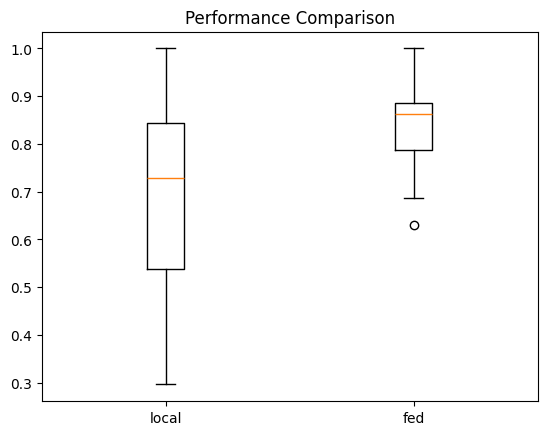

In [8]:
import numpy as np
import matplotlib.pyplot as plt

data = pd.DataFrame({'local':local_AUCs, 'fed': go_AUCs})

fig1, ax1 = plt.subplots()
ax1.set_title('Performance Comparison')
ax1.boxplot(data)
plt.xticks([1, 2], ['local', 'fed'])

# 4. Partially overlapping data scenario

In [9]:
##################
# Indices to drop columns on each data

indices = [[0,1,2,3], [2,3,4], [4,5,6], [5,6,8], [6,7,8], [0,1,2], [2,3,4,8], [4,6], [0,6,8], [1,2,7,8]]

In [10]:
# Initialize federated model
fed_rf = FederatedRandomForestClassifier(tree_aggregation_method="add", n_estimators=200, random_state=42, max_depth=2)

# To store local random forest models.
local_rfs = []

# To store results.
local_AUCs = []
local_PRAUCs = []
local_MCCs = []
go_AUCs = []
go_PRAUCs = []
go_MCCs = []

for i, (X_, Y) in enumerate(zip(Xs, Ys)):  
    X = X_.drop(X_.columns[indices[i]], axis=1)

    sss = StratifiedShuffleSplit(n_splits=1,  test_size=0.2, random_state=42)
    for _, (train_index, test_index) in enumerate(sss.split(X,Y)):
        X_train = X.iloc[train_index,:]
        y_train = Y.iloc[train_index]

        #  Initialize local model
        local_rf = LocalRandomForestClassifier(fed_rf)
        #  Train local model
        local_rf.fit(X_train, y_train)
        #  Commit local model to federated model
        local_rf.commit_local_random_forest()
        
        #  Store random forest to list for future use
        local_rfs.append(local_rf)   

for i, (X_, Y) in enumerate(zip(Xs, Ys)):  
    X = X_.drop(X_.columns[indices[i]], axis=1)

    #  Select local random forest model
    local_rf = local_rfs[i]         

    sss = StratifiedShuffleSplit(n_splits=1,  test_size=0.2, random_state=42)
    for _, (train_index, test_index) in enumerate(sss.split(X,Y)):
        X_test = X.iloc[test_index,:]
        y_test = Y.iloc[test_index]
        
        
        #  Calculate performance metrics
        cls_pred = local_rf.predict(X_test)  
        pred_prob = local_rf.predict_proba(X_test)[:,1]
        local_AUCs.append(roc_auc_score(y_test, pred_prob))
        precision, recall, thresholds = precision_recall_curve(y_test, pred_prob)
        local_PRAUCs.append(auc(recall, precision))
        local_MCCs.append(matthews_corrcoef(y_test, cls_pred))
        
        # Obtain trees from federated RF objects
        local_rf.get_updated_trees_from_federated_model()   
        # Switch from local to updated model

        #  Calculate performance metrics
        cls_pred = local_rf.predict(X_test, use_updated_federated_model = True)
        pred_prob = local_rf.predict_proba(X_test, use_updated_federated_model = True)[:,1]
        go_AUCs.append(roc_auc_score(y_test, pred_prob))
        precision, recall, thresholds = precision_recall_curve(y_test, pred_prob)
        go_PRAUCs.append(auc(recall, precision))
        go_MCCs.append(matthews_corrcoef(y_test, cls_pred))

# 5. Evaluation and Comparison of partially overlapping data scenario

([<matplotlib.axis.XTick at 0x7f79604c1d00>,
 [Text(1, 0, 'local'), Text(2, 0, 'fed')])

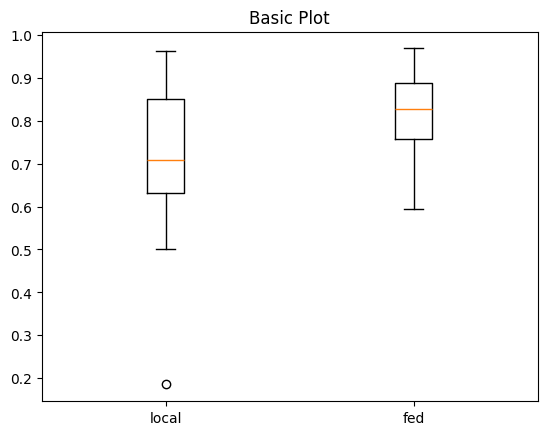

In [11]:
import numpy as np
import matplotlib.pyplot as plt

data = pd.DataFrame([local_AUCs, go_AUCs])

fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data.transpose())
plt.xticks([1, 2], ['local', 'fed'])

In [12]:
print('local rf #trees', len(local_rfs[0].local_estimators_))
print('fed rf #trees', len(local_rfs[0].updated_estimators_))

local rf #trees 200
fed rf #trees 680


# 6. Shap

In [13]:
import shap

/home/yj/miniconda3/envs/py397/lib/python3.9/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/home/yj/miniconda3/envs/py397/lib/python3.9/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/home/yj/miniconda3/envs/py397/lib/python3.9/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/home/yj/miniconda3/envs/py397/lib/python3.9/site-packages/shap/plots/colors/_colorconv.py:819: Deprecatio

In [14]:
local_rf = local_rfs[0] 
X_train = X.iloc[0,:]
y_train = Y.iloc[0]
X_test = X.iloc[0,:]

In [15]:
local_rf._force_use_updated_federated_model(False)
print(len(local_rf.estimators_))
explainer = shap.TreeExplainer(local_rf) 
shap_values = explainer.shap_values(X_train) 
#shap.summary_plot(shap_values[1], np.array(X_test)) 

200


In [16]:
shap_values

array([[ 0.11661528, -0.11661528],
       [-0.01464614,  0.01464614],
       [-0.00931073,  0.00931073],
       [ 0.05784894, -0.05784894],
       [ 0.08357111, -0.08357111]])

In [17]:
local_rf._force_use_updated_federated_model(True)
print(len(local_rf.estimators_))
explainer = shap.TreeExplainer(local_rf) 
shap_values = explainer.shap_values(X_train) 
#shap.summary_plot(shap_values[1], np.array(X_test)) 

680


In [18]:
shap_values

array([[ 0.06052742, -0.06052742],
       [ 0.10987387, -0.10987387],
       [-0.05062974,  0.05062974],
       [ 0.01039557, -0.01039557],
       [ 0.03517769, -0.03517769]])